In [1]:
#import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, Concatenate
from math import sqrt

In [2]:
# fix random seed for reproducibility
np.random.seed(7)
tf.random.set_seed(7)

In [3]:
#Final_Data = pd.read_csv("Final_data_2.csv")
Final_Data = pd.read_csv("SPAIN_data/Final_data_2_new.csv") 
Final_Data = Final_Data.set_index('time')

# Prepare input for LSTM model

In [4]:
def prepare_data_for_lstm(dataframe, first_val_day, first_test_day, days_of_test_set, features, label , window , horizon, missing_days, hours, shape = '1d'):
    X_train = []
    X_val   = []
    X_test  = []
    Y_train = []
    Y_val   = []
    Y_test  = []
    
    days = [ datetime.strptime(item[:10], "%Y-%m-%d") for item in list(dataframe.index)]
    #days = [ datetime.strptime(item.date().strftime("%Y-%m-%d"), "%Y-%m-%d") for item in list(dataframe.index)]
    
    val_date = datetime.strptime(first_val_day, "%Y-%m-%d") 
    id_first_val_day  = days.index(val_date) # Only for this example we need -1. Generally you must delete it

    test_date = datetime.strptime(first_test_day, "%Y-%m-%d")
    id_first_test_day  = days.index(test_date)  # Only for this example we need -1. Generally you must delete it
    
    id_first_train_day = window + missing_days
    
    id_of_end = id_first_test_day + days_of_test_set * hours
        
            
    for i in range( id_first_train_day , id_first_val_day , hours ):
        sample = []
        if shape == '1d':
            for j in range( window + missing_days, missing_days , -1 ):
                instance = list( dataframe.iloc[i - j][features].values )
                sample = sample + instance
        elif shape == '2d':
            for j in range( window + missing_days, missing_days , -1 ):
                instance = list( dataframe.iloc[i - j][features].values )
                sample.append(instance)
        X_train.append(sample)
        Y_train.append( list(dataframe.iloc[i:i+horizon][label].values) )
        
    for i in range( id_first_val_day , id_first_test_day , hours):
        sample = []
        if shape == '1d':
            for j in range( window + missing_days, missing_days , -1 ):
                instance = list( dataframe.iloc[i - j][features].values )
                sample = sample + instance
        elif shape == '2d':
            for j in range( window + missing_days, missing_days , -1 ):
                instance = list( dataframe.iloc[i - j][features].values )
                sample.append(instance)
        X_val.append(sample)
        Y_val.append( list(dataframe.iloc[i:i+horizon][label].values) )
    
    for i in range( id_first_test_day , id_of_end , hours ):
        sample = []
        if shape == '1d':
            for j in range( window + missing_days, missing_days, -1 ):
                instance = list( dataframe.iloc[i - j][features].values )
                sample = sample + instance
        elif shape == '2d':
            for j in range( window + missing_days, missing_days, -1 ):
                instance = list( dataframe.iloc[i - j][features].values )
                sample.append(instance)
        X_test.append(sample)
        Y_test.append( list(dataframe.iloc[i:i+horizon][label].values) ) 
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [5]:
#lstmmm
first_val_day      = '2017-1-1'
first_test_day     = '2018-1-1'
days_of_test_set   = 365

features           = ['total load actual']#, 'prev_week_load_fd', '2prev_week_load_fd', 
                     #'3prev_week_load_fd', '4prev_week_load_fd']
    
hours              = 24
label              = 'total load actual'
window             = hours * 1
horizon            = hours
black_days         = hours * 1
#date = datetime.strptime(first_test_day, "%Y-%m-%d")   #convert string to datetime
#id_first_test_day  = list(Final_Data.index).index(date)  #find the id of first test day in dataframe 
start_time1 = datetime.now()

X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_data_for_lstm(dataframe= Final_Data, 
                                    first_val_day = first_val_day, first_test_day = first_test_day,
                                    days_of_test_set = days_of_test_set, features = features, label = label, 
                                window = window, horizon = horizon, missing_days = black_days, hours = hours, shape = '2d')
start_time2 = datetime.now()
print(start_time2-start_time1)


0:00:21.365416


In [6]:
#create input array for additional features, shape
def additional_features(dataframe, first_test_day, days_of_test_set, features, time_features, window , horizon, black_days):

    X_add = []
    X_test_add  = []
    
    
    #find index of first test day
    days = [ datetime.strptime(item[:10], "%Y-%m-%d") for item in list(Final_Data.index)]

    date = datetime.strptime(first_test_day, "%Y-%m-%d")   #convert string to datetime 
    id_first_test_day  = days.index(date)  #find the id of first test day in dataframe 
    id_first_train_day = window + black_days
    id_of_end = id_first_test_day + days_of_test_set * 24
    
    for i in range( id_first_train_day , id_first_test_day , 24 ):
        
        a = list(dataframe.iloc[i:i+horizon][features].values)
        weather = []
        for item in a:
            for j in item:
                weather.append(j)
        if time_features != None:
            b = list(dataframe.iloc[i+2][time_features].values)        
            X_add.append(weather + b)             
        else:
            X_add.append(weather)
            
            
    for i in range( id_first_test_day , id_of_end , 24 ):
        
        a = list(dataframe.iloc[i:i+horizon][features].values)
        weather = []
        for item in a:
            for j in item:
                weather.append(j)
        if time_features != None:
            b = list(dataframe.iloc[i+2][time_features].values)        
            X_test_add.append(weather + b)             
        else:
            X_test_add.append(weather)
        
            
    return X_add, X_test_add 

In [7]:
first_test_day     = '2017-1-1'
days_of_test_set   = 365
"""    features = ['prev_week_load', '2prev_week_load', '3prev_week_load', '4prev_week_load',
            'temp_Madrid','pressure_Madrid','humidity_Madrid','wind_speed_Madrid',
            'temp_Seville','pressure_Seville','humidity_Seville','wind_speed_Seville', 
            'temp_Barcelona','pressure_Barcelona','humidity_Barcelona', 'wind_speed_Barcelona',
            'temp_Valencia','pressure_Valencia','humidity_Valencia', 'wind_speed_Valencia', 
            'temp_Bilbao','pressure_Bilbao','humidity_Bilbao', 'wind_speed_Bilbao']
 
"""
features = ['prev_week_load', '2prev_week_load', '3prev_week_load', '4prev_week_load','humidity_Madrid_fd_n','temp_Madrid_fd_n']

#time_features = ['weekday_fd','month_fd', 'day_of_year_fd', 'day_of_month_fd', 'weekdays_weekends_fd' ]

time_features = ['weekday_sin_fd','month_sin_fd', 'day_of_year_sin_fd', 'day_of_month_sin_fd',  
                 'weekday_cos_fd','month_cos_fd', 'day_of_year_cos_fd', 'day_of_month_cos_fd', 'weekdays_weekends_fd']
window             = 24*1
horizon            = 24
black_days         = 24*1
#date = datetime.strptime(first_test_day, "%Y-%m-%d")   #convert string to datetime
#id_first_test_day  = list(Final_Data.index).index(date)  #find the id of first test day in dataframe 
start_time1 = datetime.now()

X_add, X_test_add = additional_features(Final_Data, first_test_day = first_test_day, days_of_test_set = days_of_test_set,
                                        features = features, time_features = time_features , window = window,
                                         horizon = horizon, black_days = black_days)

start_time2 = datetime.now()
print(start_time2-start_time1)

0:00:01.826883


In [8]:
X_train= np.asarray(X_train)
X_val= np.asarray(X_val)
X_add = np.asarray(X_add)
Y_train = np.asarray(Y_train)
Y_val = np.asarray(Y_val)
X_test = np.asarray(X_test)
X_test_add = np.asarray(X_test_add)
Y_test = np.asarray(Y_test)

In [9]:
#create evaluation function to use them in lstms training
#create MAPE and MAE functions
def mean_absolute_percentage_error(y_true, y_pred): 
    mape=np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape
def mean_absolute_error(y_true, y_pred): 
    MAE = np.mean(np.abs(y_true-y_pred))
    return MAE
#create a function to evaluate LSTM with MAPE, MAE, RMSE, RRMSE and r2_score
def evaluation_function(y_true, y_pred):

    MAPE=mean_absolute_percentage_error(y_true, y_pred)
    print(f'MAPE: {"{:.5f}".format(MAPE)} %')
    MAE = mean_absolute_error(y_true, y_pred)
    print(f'MAE : {"{:.5f}".format(MAE)}')

    #RMSE and RRMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'RMSE: {"{:.5f}".format(rmse)}')

    RRMSE = (rmse/np.mean(y_true))*100
    print(f'RRMSE: {"{:.5f}".format(RRMSE)} % ')      
    r2 = r2_score(y_true, y_pred)
    print(f'Test R^2 score: {"{:.5f}".format(r2)}')
    
    return MAPE, MAE, rmse, RRMSE, r2
          
def yearly_error(y_true, y_pred):
    mape = []
    for i in range(0, len(y_pred)):
        for j in range(0, len(y_pred[0])):
            mape.append(mean_absolute_percentage_error(y_true[i][j],y_pred[i][j]))
    #count how many hours has error <=10%, >10% and <15%, >15% and find the percentage of every month
    count1 = 0
    count2 = 0
    count3 = 0
    for item in mape:
        if item <= 10:
            count1 += 1
        elif item <= 15:
            count2 += 1
        else :
            count3 += 1
    print('for the year')
    percentage1 =(count1*100) /(len(y_pred)*len(y_pred[0]))
    print(f'{"{:.3f}".format(percentage1)}% has error <=10')
    percentage2 =(count2*100) /(len(y_pred)*len(y_pred[0]))
    print(f'{"{:.3f}".format(percentage2)}% has error <=15')
    percentage3 =(count3*100) /(len(y_pred)*len(y_pred[0]))
    print(f'{"{:.3f}".format(percentage3)}% has error >15')
          
    return percentage1,percentage2,percentage3

# Built second architecture

In [10]:
### built LSTM model
keras.backend.clear_session()

In [11]:
#Adaptive learning rate
# epochs     = [30, 65, 100]
# values     = [0.005, 0.001, 0.0005,0.0001]
len_data = len(X_train)
batch_size = 41

In [20]:
#delete model and # fix random seed for reproducibility
keras.backend.clear_session()
np.random.seed(7)
tf.random.set_seed(7)

In [21]:
#LSTM with second feature input
mdl_input1 = keras.Input(shape=(len(X_train[0]), len(X_train[0][0])))
x = LSTM(200, activation='tanh', return_sequences=True)(mdl_input1)
x = Dropout(0.3)(x)
x = LSTM(100, activation='tanh')(x)
x = Dropout(0.3)(x)

mdl_input2 = keras.Input(shape=len(X_add[0]))
y = Dense(200,activation = 'tanh')(mdl_input2)
concat = Concatenate(axis=1)([x, y])

#x = Dense(50)(concat)
#x = Dense(100)(concat)
#x = Dense(200,activation = 'relu')(concat)
#x = Dense(50,activation = 'linear')(x)
output = Dense(horizon,activation = 'linear')(concat)
model = keras.Model([mdl_input1, mdl_input2], output)

# compile the model ...
#model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)) 
model.compile(loss='mape', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) ) 


In [12]:
#model =keras.models.load_model('best_model_Arch2_532epochs')

# Training

Epoch 1/9
18/18 - 1s - loss: 5.9073 - val_loss: 6.3291
Epoch 2/9
18/18 - 1s - loss: 5.7776 - val_loss: 6.3964
Epoch 3/9
18/18 - 1s - loss: 5.7665 - val_loss: 6.3271
Epoch 4/9
18/18 - 1s - loss: 5.7295 - val_loss: 6.3385
Epoch 5/9
18/18 - 1s - loss: 5.7511 - val_loss: 6.3203
Epoch 6/9
18/18 - 1s - loss: 5.7062 - val_loss: 6.3331
Epoch 7/9
18/18 - 1s - loss: 5.7083 - val_loss: 6.3647
Epoch 8/9
18/18 - 1s - loss: 5.6992 - val_loss: 6.2965
Epoch 9/9
18/18 - 1s - loss: 6.0104 - val_loss: 6.2661


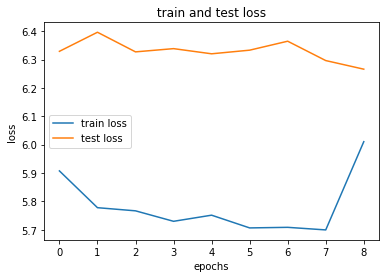

training time is:  0:00:06.774758


In [23]:
## fit network
start_time1 = datetime.now()
history = model.fit([X_train, X_add], Y_train,epochs=9, batch_size=batch_size,
                    validation_data=([X_val,X_test_add], Y_val), verbose=2, shuffle=False)
#plot the losses
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title(' train and test loss ')
plt.legend()
plt.show()

start_time2 = datetime.now()
print('training time is: ', start_time2-start_time1)


In [25]:
#model.save('best_model_Arch2_532epochs')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: best_model_Arch2_532epochs\assets


# Test and Evaluation 

In [13]:
# make a prediction and evaluation
Y_pred = model.predict([X_val, X_test_add])


#evaluation
MAPE, MAE, rmse, RRMSE, r2 =  evaluation_function(y_true= Y_val, y_pred= Y_pred)
print("\n")
per1,per2,per3 = yearly_error(y_true = Y_val , y_pred = Y_pred)
print("\n")


MAPE: 6.26608 %
MAE : 0.04337
RMSE: 0.06108
RRMSE: 8.68063 % 
Test R^2 score: 0.36658


for the year
81.062% has error <=10
10.183% has error <=15
8.756% has error >15




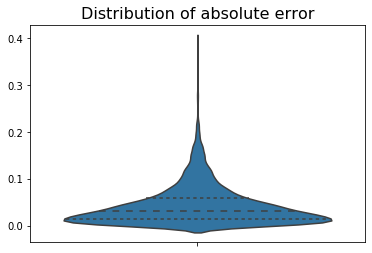

In [17]:
#violin plot for forecasting load
ax = sns.violinplot(y=abs(Y_test-Y_pred), inner='quartile')
ax.set_title('Distribution of absolute error', fontsize=16);

In [18]:
#print median, mean, 25%, 75%, iqr
y=abs(Y_test-Y_pred)
median_ae = np.median(y)
print("median", median_ae)
mean_ae = np.mean(y)
print("mean", mean_ae)
q75, q25 = np.percentile(y, [75 ,25])
iqr = q75 - q25
print('q75', q75)
print('q25', q25)
print('iqr', iqr)

median 0.03126585191377096
mean 0.043784048836115474
q75 0.059019971887512845
q25 0.014322792992902317
iqr 0.04469717889461053


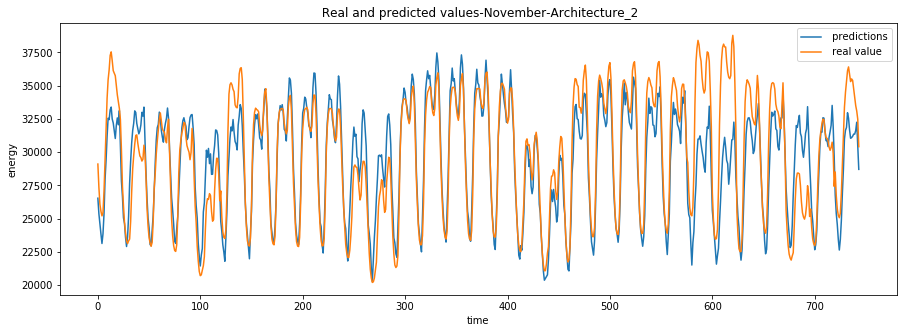

In [19]:
#plot predictions and actual values of load , for January
#select the month 1>Jan, 2>feb, 3>Mar
Month = 11
Ytest= np.array(Y_test)
predictions = Y_pred.flatten()
actual = Ytest.flatten()
pr = predictions*41015
ac = actual*41015
fig = plt.figure(figsize=(15,5))
plt.plot(  pr[31*24*(Month-1):31*24*Month] ,label = " predictions" )
plt.plot(  ac[31*24*(Month-1):31*24*Month] , label = " real value ")
plt.xlabel('time')
plt.ylabel('energy')
plt.title(' Real and predicted values-November-Architecture_2')
plt.legend()
plt.show()

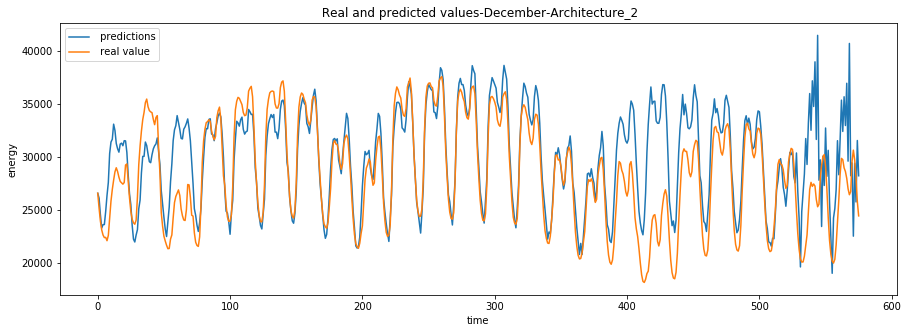

In [20]:
#plot predictions and actual values of load , for January
#select the month 1>Jan, 2>feb, 3>Mar
Month = 12
Ytest= np.array(Y_test)
predictions = Y_pred.flatten()
actual = Ytest.flatten()
pr = predictions*41015
ac = actual*41015
fig = plt.figure(figsize=(15,5))
plt.plot(  pr[31*24*(Month-1):31*24*Month] ,label = " predictions" )
plt.plot(  ac[31*24*(Month-1):31*24*Month] , label = " real value ")
plt.xlabel('time')
plt.ylabel('energy')
plt.title(' Real and predicted values-December-Architecture_2')
plt.legend()
plt.show()

In [21]:
#model.save('model_arch2')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_arch2\assets
